In [ ]:
import pandas as pd
from pandas import qcut
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors
import statsmodels.api as sm
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

In [ ]:
train = pd.read_csv('train_u6lujuX_CVtuZ9i.csv')
predict = pd.read_csv('test_Y3wMUE5_7gLdaTN.csv')

##Data Preparation

In [ ]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [ ]:
predict.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [ ]:
train['Credit_History'].unique()

array([ 1.,  0., nan])

In [ ]:
train=train.drop(columns=['Loan_ID'])
predict=predict.drop(columns=['Loan_ID'])

In [ ]:
train_knn = train.copy()
label_encoders = {}
for column in train_knn.select_dtypes(include=['object']).columns:
  if column != 'Loan_ID':
    le = LabelEncoder()
    train_knn[column] = train_knn[column].astype(str)
    train_knn[column] = le.fit_transform(train_knn[column])
    label_encoders[column] = le
knn_imputer = KNNImputer(n_neighbors=5)
train_knn_filled = pd.DataFrame(knn_imputer.fit_transform(train_knn), columns=train_knn.columns)
for column in label_encoders:
    le = label_encoders[column]
    train_knn_filled[column] = le.inverse_transform(train_knn_filled[column].astype(int))

In [ ]:
train_knn_filled.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

##EDA

array([[<Axes: title={'center': 'ApplicantIncome'}>,
        <Axes: title={'center': 'CoapplicantIncome'}>],
       [<Axes: title={'center': 'LoanAmount'}>,
        <Axes: title={'center': 'Loan_Amount_Term'}>],
       [<Axes: title={'center': 'Credit_History'}>, <Axes: >]],
      dtype=object)

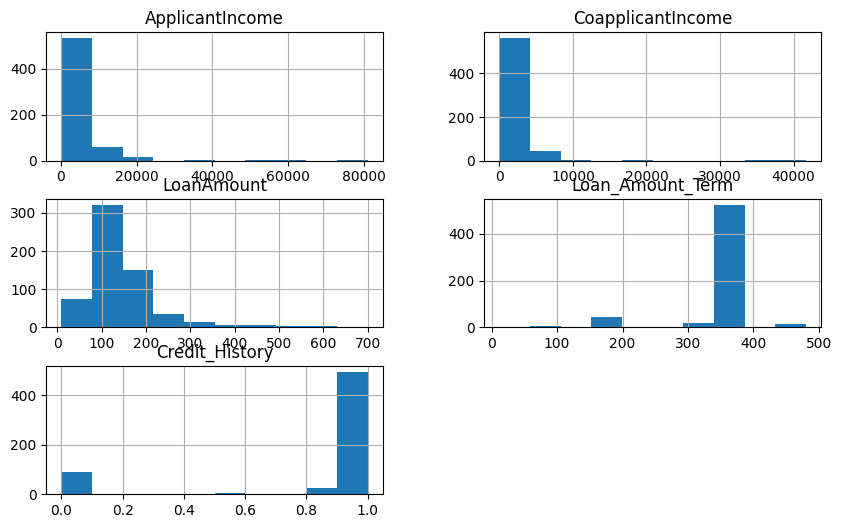

In [ ]:
train_knn_filled.hist(figsize=(10,6))

In [ ]:
train_knn_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), object(7)
memory usage: 57.7+ KB


<Axes: >

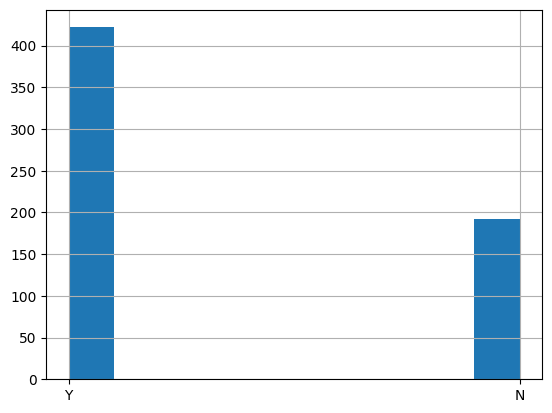

In [ ]:
train_knn_filled['Loan_Status'].hist()

Text(0.5, 1.0, 'Loan Status and Education')

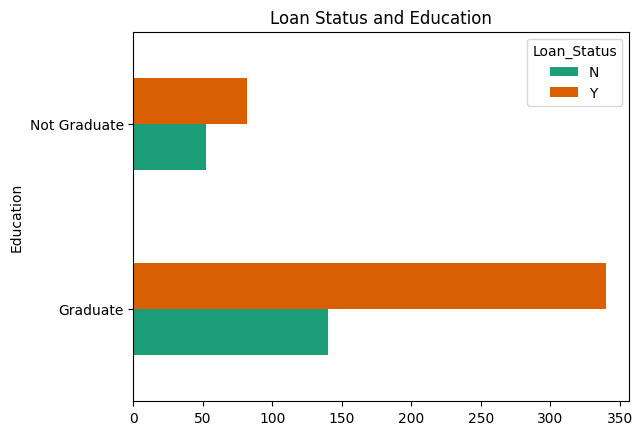

In [ ]:
dfn = train_knn_filled.groupby(['Loan_Status','Education']).count().unstack('Loan_Status')
dfn['Gender'].plot(kind='barh',color=sns.palettes.mpl_palette('Dark2'))
plt.title('Loan Status and Education')

In [ ]:
dfn = train_knn_filled
dfn['Total_Income']=dfn['ApplicantIncome']+dfn['CoapplicantIncome']
dfn['Total_Income'].describe()

count      614.000000
mean      7024.705081
std       6458.663872
min       1442.000000
25%       4166.000000
50%       5416.500000
75%       7521.750000
max      81000.000000
Name: Total_Income, dtype: float64

In [ ]:
dfn['income_group']=dfn['Total_Income'].apply(lambda x:str(round(x,-4))+' '+'to'+' '+str(round(x,-4)+10000))

<Axes: >

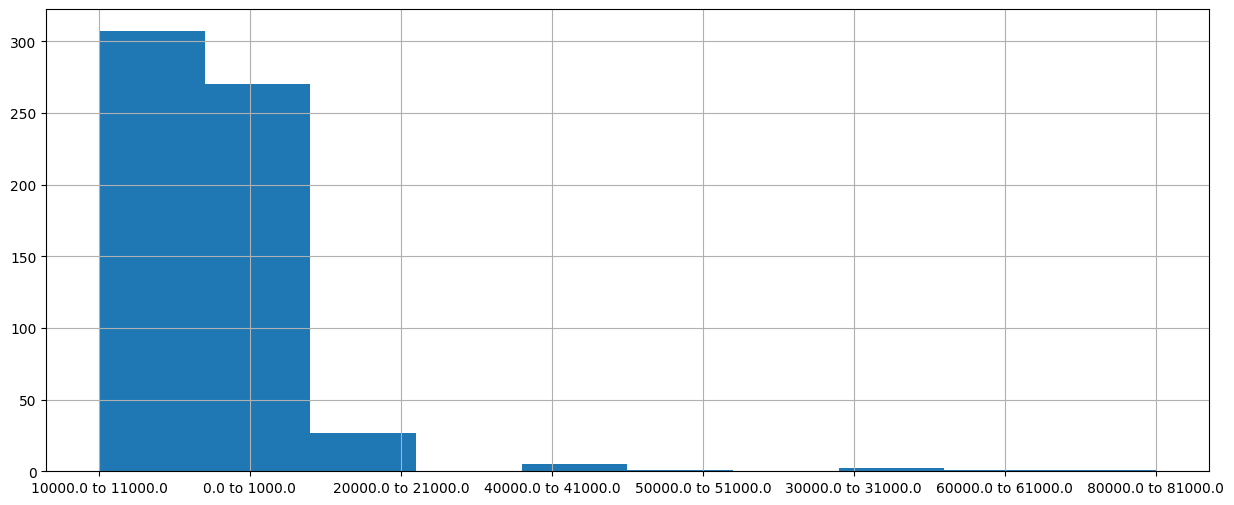

In [ ]:
dfn['income_group'].hist(figsize=(15,6))

Text(0.5, 1.0, 'Loan Status and Total Income')

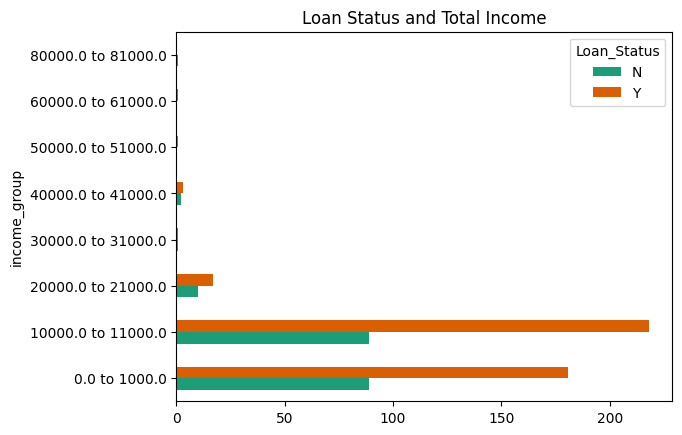

In [ ]:
dfn = dfn.groupby(['Loan_Status','income_group']).count().unstack('Loan_Status')
dfn['Gender'].plot(kind='barh',color=sns.palettes.mpl_palette('Dark2'))
plt.title('Loan Status and Total Income')

Text(0.5, 1.0, 'Loan Status and Credit History')

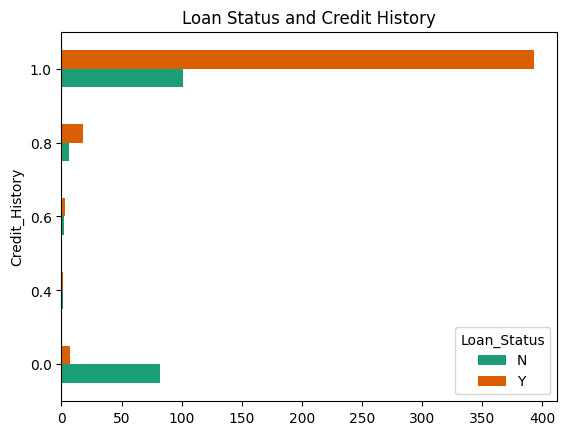

In [ ]:
dfn = train_knn_filled.groupby(['Loan_Status','Credit_History']).count().unstack('Loan_Status')
dfn['Gender'].plot(kind='barh',color=sns.palettes.mpl_palette('Dark2'))
plt.title('Loan Status and Credit History')

In [ ]:
dfn=train_knn_filled
dfn['Dependents']=dfn['Dependents'].apply(lambda x:x.replace('3+','3'))

<Axes: >

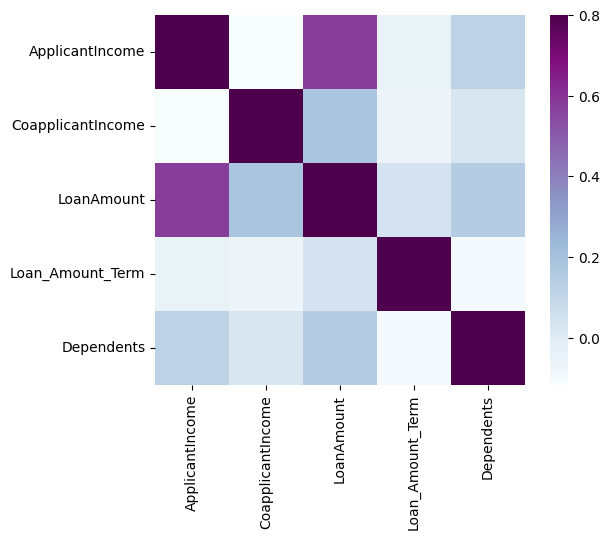

In [ ]:

sns.heatmap(dfn[['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Dependents']].corr(), vmax=0.8, square=True, cmap='BuPu')

##Preparation#2

In [ ]:
traindf=train_knn_filled

In [ ]:
traindf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    float64
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), object(7)
memory usage: 57.7+ KB


In [ ]:
#for numerical variables
nvar_list = ['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term']
#for categorical variables
cvar_list = ['Gender','Married','Education','Self_Employed','Credit_History','Property_Area','Dependents']

traindf[nvar_list] = traindf[nvar_list].astype('float64')
traindf[cvar_list] = traindf[cvar_list].astype('category')

In [ ]:
traindf[nvar_list] = (traindf[nvar_list] - traindf[nvar_list].mean()) / traindf[nvar_list].std() #standardize numerical variables

##Classification Tree

In [ ]:
# Required package: scikit-learn. Package name in Python: sklearn
# Required subpackage: model_selection. Required function name: train_test_split
from sklearn.model_selection import train_test_split

# Placeholder variables: df4partition, testpart_size
# test_size specifies the percentage for the test partition
testpart_size = 0.2

# random_state specifies the seed for random number generator.
# random_state = 1 unless otherwised noted
df_nontestData, df_testData = train_test_split(traindf, test_size=testpart_size, random_state=1)

In [ ]:
# Classification tree

# Required package: scikit-learn. Package name in Python: sklearn
# Required subpackage: tree
# Required function name: DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier


# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'Loan_Status'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])

X=pd.get_dummies(X)

from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

# A user-defined function summary_tree to display a classification tree
def summary_tree(model_object):
  dot_data = StringIO()
  export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  output_imagefile = 'tree.png'
  graph.write_png(output_imagefile)
  return output_imagefile

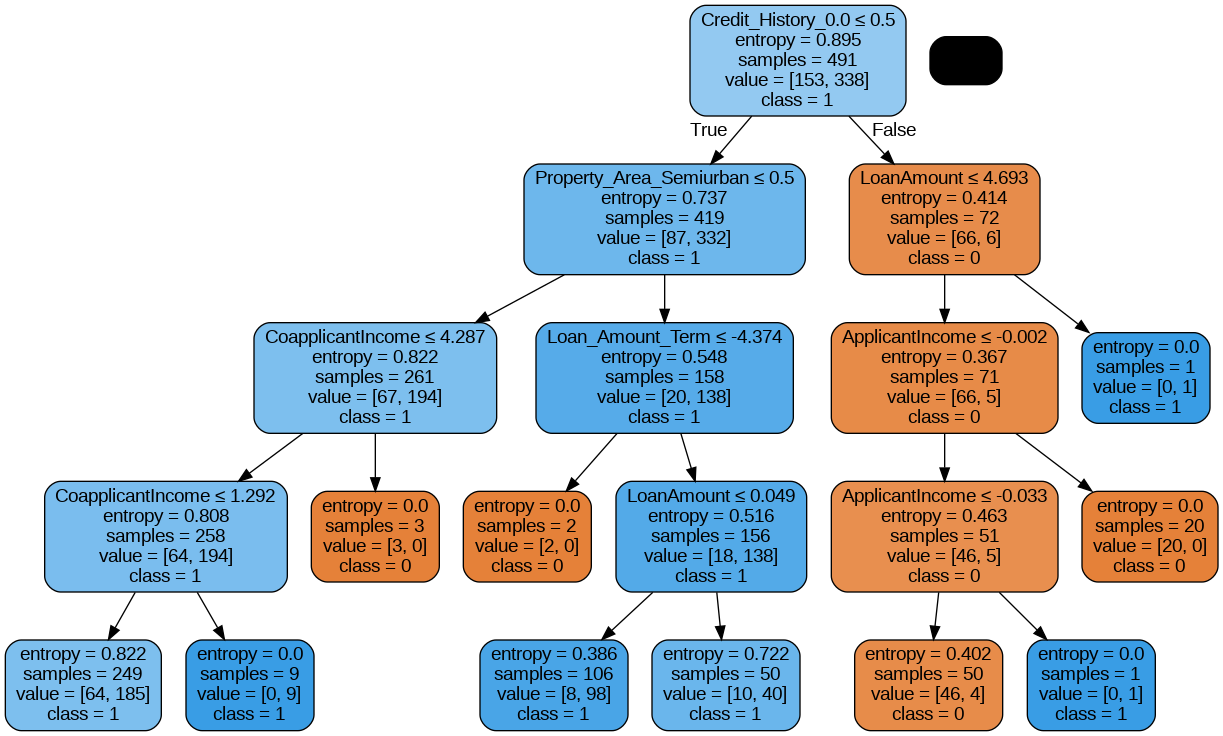

In [ ]:
# Here we specify within which range of depths we will search for the best pruned tree
kfolds = 5
maximum_depth = 50
minimum_depth = 1
param_grid = {'max_depth': list(range(minimum_depth, maximum_depth+1))}

from sklearn.model_selection import GridSearchCV

gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

Image(summary_tree(clf_BPT))

In [ ]:
# Display the level of depth of the best pruned tree
print(clf_BPT.get_depth())

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])
X_test=pd.get_dummies(X_test)

4


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report
print(roc_auc_score(y_test_actual, clf_BPT.predict_proba(X_test)[:,1]))

0.753052503052503


In [ ]:
from sklearn import metrics
metrics.confusion_matrix(y_test_actual, clf_BPT.predict(X_test))

array([[16, 23],
       [ 1, 83]])

In [ ]:
#Accuracy
clf_BPT.score(X_test, y_test_actual)

0.8048780487804879

In [ ]:
print(classification_report(y_test_actual, clf_BPT.predict(X_test)))

              precision    recall  f1-score   support

           N       0.94      0.41      0.57        39
           Y       0.78      0.99      0.87        84

    accuracy                           0.80       123
   macro avg       0.86      0.70      0.72       123
weighted avg       0.83      0.80      0.78       123



In [ ]:
#feature_importances
feature_importances = clf_BPT.feature_importances_

In [ ]:
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

                    Feature  Importance
20       Credit_History_0.0    0.733169
1         CoapplicantIncome    0.070768
26  Property_Area_Semiurban    0.056134
2                LoanAmount    0.052150
3          Loan_Amount_Term    0.044294
0           ApplicantIncome    0.043485
16   Education_Not Graduate    0.000000
25      Property_Area_Rural    0.000000
24       Credit_History_1.0    0.000000
23       Credit_History_0.8    0.000000
22       Credit_History_0.6    0.000000
21       Credit_History_0.4    0.000000
19        Self_Employed_nan    0.000000
18        Self_Employed_Yes    0.000000
17         Self_Employed_No    0.000000
14           Dependents_nan    0.000000
15       Education_Graduate    0.000000
13            Dependents_3+    0.000000
12             Dependents_2    0.000000
11             Dependents_1    0.000000
10             Dependents_0    0.000000
9               Married_nan    0.000000
8               Married_Yes    0.000000
7                Married_No    0.000000


##Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'Loan_Status'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])
X = pd.get_dummies(X)

# Run Logistic regression with pre-specified penalty level (alpha)
# Placeholder variable: alpha
alpha = 10

# The Logistic regression results are put into a model object clf
clf = LogisticRegression(C=1/alpha, penalty='l1', solver='saga', max_iter=200, random_state=1).fit(X,y)

# A user-defined function summary_coef
# to display the estimated coefficients of a model candidate obtained by the Logistic Regression analysis
def summary_coef(model_object):
  n_predictors = X.shape[1]
  model_coef = pd.DataFrame(model_object.coef_.reshape(1, n_predictors), columns=X.columns.values)
  model_coef['Intercept'] = model_object.intercept_
  return model_coef.transpose()

print(summary_coef(clf))


                                0
ApplicantIncome          0.000000
CoapplicantIncome       -0.057943
LoanAmount               0.000000
Loan_Amount_Term         0.000000
Gender_Female            0.000000
Gender_Male              0.000000
Gender_nan               0.000000
Married_No               0.000000
Married_Yes              0.000000
Married_nan              0.000000
Dependents_0             0.000000
Dependents_1             0.000000
Dependents_2             0.000000
Dependents_3+            0.000000
Dependents_nan           0.000000
Education_Graduate       0.000000
Education_Not Graduate   0.000000
Self_Employed_No         0.000000
Self_Employed_Yes        0.000000
Self_Employed_nan        0.000000
Credit_History_0.0      -2.216572
Credit_History_0.4       0.000000
Credit_History_0.6       0.000000
Credit_History_0.8       0.000000
Credit_History_1.0       0.243738
Property_Area_Rural      0.000000
Property_Area_Semiurban  0.216409
Property_Area_Urban      0.000000
Intercept     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
# Run Logistic regression with k-fold cross validation with k=5
# Placeholder variable: kfolds
kfolds = 5

# Here we specify within which range of the penalty levels we will search for the optimal penalty level,
# i.e., the level that leads to the best model candidate
# We search the optimal alpha within [min_alpha, max_alpha]
min_alpha = 0.02
max_alpha = 50

# C is the inverse of alpha. LogisticRegression and LogisticRegressionCV require inverse alpha
# as the parameter values for specifying penalty levels
max_C = 1/min_alpha
min_C = 1/max_alpha

# We further discretize the continuous C range [min_C, max_C] into n individual points of C
# We train n model candidates each of which corresponds to one individual C point
n_candidates = 50

# We store the list of individual C points into C_list
C_list = list(np.linspace(min_C, max_C, num=n_candidates))

clf_optimal = LogisticRegressionCV(Cs=C_list, cv=kfolds, scoring='roc_auc', penalty='l1', solver='saga', max_iter=100, random_state=1, n_jobs=-1).fit(X,y)

# Display the estimated coefficients of the final selected model
print(summary_coef(clf_optimal))

# Display the optimal alpha that yields the final selected model (the best model candidate)
print(1/clf_optimal.C_)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

                                0
ApplicantIncome          0.008782
CoapplicantIncome       -0.153911
LoanAmount              -0.041092
Loan_Amount_Term        -0.101774
Gender_Female            0.077446
Gender_Male              0.000000
Gender_nan               0.000000
Married_No              -0.500621
Married_Yes              0.000000
Married_nan              0.000000
Dependents_0            -0.083088
Dependents_1            -0.261035
Dependents_2             0.021201
Dependents_3+            0.349494
Dependents_nan           0.000000
Education_Graduate       0.146196
Education_Not Graduate  -0.200461
Self_Employed_No         0.000000
Self_Employed_Yes        0.000000
Self_Employed_nan        0.056281
Credit_History_0.0      -3.070732
Credit_History_0.4       0.000000
Credit_History_0.6       0.000000
Credit_History_0.8       0.320835
Credit_History_1.0       0.620722
Property_Area_Rural      0.000000
Property_Area_Semiurban  0.744195
Property_Area_Urban     -0.007628
Intercept     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
y_test_actual = df_testData[DV]

X_test = df_testData.drop(columns=[DV])

X_test = pd.get_dummies(X_test)

from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test_actual, clf_optimal.predict_proba(X_test)[:,1]))

0.7496947496947497


In [ ]:
clf_optimal = LogisticRegressionCV(Cs=C_list, cv=kfolds, scoring='accuracy', penalty='l1', solver='saga', max_iter=100, random_state=1, n_jobs=-1).fit(X,y)

# Display the estimated coefficients of the final selected model
print(summary_coef(clf_optimal))

# Display the optimal alpha that yields the final selected model (the best model candidate)
print(1/clf_optimal.C_)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

                                0
ApplicantIncome          0.008782
CoapplicantIncome       -0.153911
LoanAmount              -0.041092
Loan_Amount_Term        -0.101774
Gender_Female            0.077446
Gender_Male              0.000000
Gender_nan               0.000000
Married_No              -0.500621
Married_Yes              0.000000
Married_nan              0.000000
Dependents_0            -0.083088
Dependents_1            -0.261035
Dependents_2             0.021201
Dependents_3+            0.349494
Dependents_nan           0.000000
Education_Graduate       0.146196
Education_Not Graduate  -0.200461
Self_Employed_No         0.000000
Self_Employed_Yes        0.000000
Self_Employed_nan        0.056281
Credit_History_0.0      -3.070732
Credit_History_0.4       0.000000
Credit_History_0.6       0.000000
Credit_History_0.8       0.320835
Credit_History_1.0       0.620722
Property_Area_Rural      0.000000
Property_Area_Semiurban  0.744195
Property_Area_Urban     -0.007628
Intercept     

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
from sklearn import metrics
metrics.confusion_matrix(y_test_actual, clf_optimal.predict(X_test))

array([[16, 23],
       [ 1, 83]])

In [ ]:
clf_optimal.score(X_test, y_test_actual )

0.8048780487804879

In [ ]:
print(classification_report(y_test_actual, clf_optimal.predict(X_test)))

              precision    recall  f1-score   support

           N       0.94      0.41      0.57        39
           Y       0.78      0.99      0.87        84

    accuracy                           0.80       123
   macro avg       0.86      0.70      0.72       123
weighted avg       0.83      0.80      0.78       123



##Neural Network

In [ ]:
from sklearn.neural_network import MLPClassifier

DV = 'Loan_Status'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])

X=pd.get_dummies(X)

alpha = 0.1
hls = 3

clf = MLPClassifier(solver='lbfgs', alpha=alpha, hidden_layer_sizes=hls, max_iter=2000, random_state=1).fit(X,y)

def summary_nn(model_object):
  coef_structure = [coef.shape for coef in model_object.coefs_]

  n_hidden_nodes = coef_structure[0][1]
  n_input_nodes = coef_structure[0][0]

  print('Neural Network Model Summary \n')

  print('Section 0. Penalty level alpha:', model_object.alpha)

  print('\nSection 1. Input (I) -> Hidden (H) - Weight (W): \n')

  for i in range(n_input_nodes):
    for j in range(n_hidden_nodes):
      print('I:', i+1, '-> H:', j+1, '- W:', model_object.coefs_[0][i][j])

  print('\nSection 2. Hidden (H) - Node Bias (B): \n')
  for j in range(n_hidden_nodes):
    print('H:', j+1, '- B:', model_object.intercepts_[0][j])

  print('\nSection 3. Hidden (H) -> Output (O) - Weight (W): \n')
  for j in range(n_hidden_nodes):
    print('H:', j+1, '-> O - W:', model_object.coefs_[1][j][0])

  print('\nSection 4. Output (O) - Node Bias (B): \n')
  print('O - B:', model_object.intercepts_[1][0])

summary_nn(clf)

Neural Network Model Summary 

Section 0. Penalty level alpha: 0.1

Section 1. Input (I) -> Hidden (H) - Weight (W): 

I: 1 -> H: 1 - W: -0.14405624863027494
I: 1 -> H: 2 - W: 0.16142191762739208
I: 1 -> H: 3 - W: -0.009325732085610163
I: 2 -> H: 1 - W: 0.039822540439973166
I: 2 -> H: 2 - W: -0.13728755161641698
I: 2 -> H: 3 - W: 0.037937066443334735
I: 3 -> H: 1 - W: -0.26030287072780567
I: 3 -> H: 2 - W: 0.15198776197447955
I: 3 -> H: 3 - W: -0.21008831116202073
I: 4 -> H: 1 - W: 0.03951645147092945
I: 4 -> H: 2 - W: -0.07460302036906827
I: 4 -> H: 3 - W: -0.03954014808136957
I: 5 -> H: 1 - W: -0.5658593725736555
I: 5 -> H: 2 - W: 0.7706833086682948
I: 5 -> H: 3 - W: -0.24932574630955534
I: 6 -> H: 1 - W: 0.41909364932345494
I: 6 -> H: 2 - W: -0.4323922318862172
I: 6 -> H: 3 - W: -0.10920183528283822
I: 7 -> H: 1 - W: -0.329256701761013
I: 7 -> H: 2 - W: -0.27468383369946536
I: 7 -> H: 3 - W: 0.09742202788030226
I: 8 -> H: 1 - W: -0.2167855180155993
I: 8 -> H: 2 - W: -0.6746614474778

In [ ]:
kfolds = 5

min_hls = 1
max_hls = 10

min_alpha = 0.0001
max_alpha = 10
n_alpha = 10

import numpy as np
param_grid = {'hidden_layer_sizes':np.arange(min_hls, max_hls), 'alpha': list(np.linspace(min_alpha, max_alpha, num=n_alpha))}

In [ ]:
from sklearn.model_selection import GridSearchCV

gridsearch = GridSearchCV(MLPClassifier(solver='lbfgs', max_iter=2000, random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_NN = gridsearch.best_estimator_

# Display the resulting best network modele
summary_nn(clf_NN)

Neural Network Model Summary 

Section 0. Penalty level alpha: 3.3334

Section 1. Input (I) -> Hidden (H) - Weight (W): 

I: 1 -> H: 1 - W: -0.00014409769765136936
I: 1 -> H: 2 - W: 0.0006113409705505009
I: 1 -> H: 3 - W: 0.019994989576428784
I: 1 -> H: 4 - W: -0.07403400045149866
I: 1 -> H: 5 - W: 0.021052143521329048
I: 1 -> H: 6 - W: 0.1234018146136337
I: 1 -> H: 7 - W: 0.023392226117320076
I: 2 -> H: 1 - W: -3.386134458525079e-05
I: 2 -> H: 2 - W: 0.00010863903525528094
I: 2 -> H: 3 - W: 0.33558391370753704
I: 2 -> H: 4 - W: 0.10861742848044163
I: 2 -> H: 5 - W: -0.5410031639618436
I: 2 -> H: 6 - W: -0.1685622953003482
I: 2 -> H: 7 - W: -0.09391557846291387
I: 3 -> H: 1 - W: 0.0003175609964548438
I: 3 -> H: 2 - W: 0.0002923668592664837
I: 3 -> H: 3 - W: -0.3265633173962484
I: 3 -> H: 4 - W: -0.39790338933324876
I: 3 -> H: 5 - W: -0.21339824953437508
I: 3 -> H: 6 - W: 0.04662956268070672
I: 3 -> H: 7 - W: -0.022106010592843766
I: 4 -> H: 1 - W: -0.00013413873719690363
I: 4 -> H: 2 -

In [ ]:
y_test_actual = df_testData[DV]
X_test = df_testData.drop(columns=[DV])
X_test = pd.get_dummies(X_test)

In [ ]:
from sklearn import metrics

# Display the confusion matrix over the test partition
metrics.confusion_matrix(y_test_actual, clf_NN.predict(X_test))

array([[16, 23],
       [ 4, 80]])

In [ ]:
clf_NN.score(X_test, y_test_actual)

0.7804878048780488

In [ ]:
print(classification_report(y_test_actual, clf_NN.predict(X_test)))

              precision    recall  f1-score   support

           N       0.80      0.41      0.54        39
           Y       0.78      0.95      0.86        84

    accuracy                           0.78       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.78      0.76       123

